# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchdiffeq

from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import numpy as np
import pickle
import itertools
import math


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

# b. MNIST Data Loader

In [3]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 256
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. Class Conditional Conditional Flow Matching**

# a. Building Blocks

In [4]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
          x1 = self.conv1(x)
          x2 = self.conv2(x1)
          if self.same_channels:
              out = x + x2
          else:
              out = x1 + x2
          return out / 1.414


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class UNet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(UNet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(up1 + temb1, down2)
        up3 = self.up2(up2 + temb2, down1)
        up2 = self.up1(up1 + temb1, down2)
        up3 = self.up2(up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

# b. Optimal Transport Conditional Vector Fields

In [5]:
def pad_t_like_x(t, x):
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))


class ConditionalFlowMatcher:
    def __init__(self, sigma=0.0):
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        ##################
        ### Problem 1 (a): mean_t
        ##################
        return t * x1

    def compute_sigma_t(self, t):
        ##################
        ### Problem 1 (b): sigma_t
        ##################
        return 1 - (1 - self.sigma) * t

    def compute_conditional_flow(self, x0, x1, t, xt):
        ##################
        ### Problem 1 (c): ut(x1|x0) (I think this is ut(xt|x1)?)
        ##################
        return (x1 - (1 - self.sigma) * xt) / (1 - (1 - self.sigma) * t)

    def sample_xt(self, x0, x1, t, epsilon):
        ##################
        ### Problem 1 (d): xt
        ##################
        mu_t_x = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        xt = mu_t_x + sigma_t * epsilon
        return xt

    def sample_noise_like(self, x):
        return torch.randn_like(x)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], "t has to have batch size dimension"
        t_broadcast = t[:, None, None, None]

        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t_broadcast, eps)
        ut = self.compute_conditional_flow(x0, x1, t_broadcast, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

# c. Training Functions

In [16]:
def show_results(model, ode_method="dopri5", ax=None):
    with torch.no_grad():
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(x, t),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method=ode_method,
        )

    grid = make_grid(
        traj[-1, :100].view([-1, 1, 28, 28]).clip(0, 1),
        value_range=(0, 1),
        padding=0,
        nrow=10,
    )

    img = ToPILImage()(grid)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img)
    plt.show()


def train_main_loop(n_epochs, optimizer, FM, model):
    losses = []
    for epoch in range(n_epochs):
        print(f"epoch {epoch}")
        pbar = train_loader
        for i, data in enumerate(pbar):
            optimizer.zero_grad()
            x1 = data[0].to(device)
            x0 = torch.randn_like(x1)
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
            vt = model(xt, t)
            loss = torch.mean((vt - ut) ** 2)
            loss.backward()
            optimizer.step()
            if i%50==0:
                print(f"[{i}/235] loss: {loss.item():.4f}", end='\r')
            losses.append(loss.item())

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[1].plot(np.arange(len(losses)) / len(train_loader), losses)
        axes[1].set_xlabel("epochs")
        axes[1].set_ylabel("loss")
        show_results(model, "dopri5", axes[0])
    torch.save(model.state_dict(), f"/workspace/CFM_epoch={n_epochs}.pth")

# e. Training


epoch 0


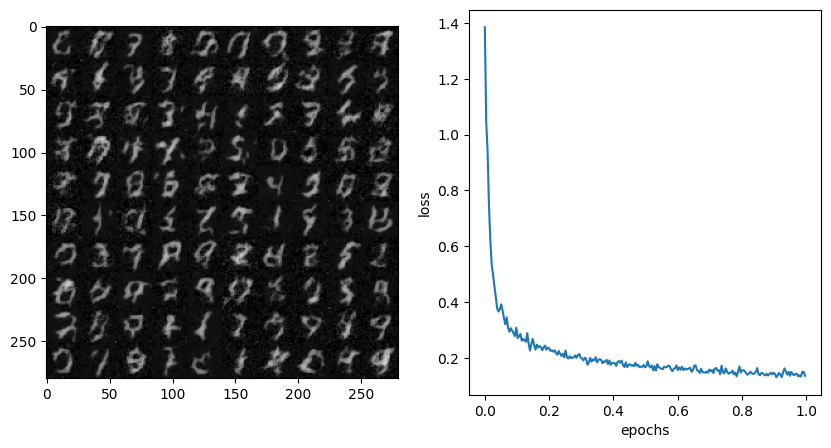

epoch 1


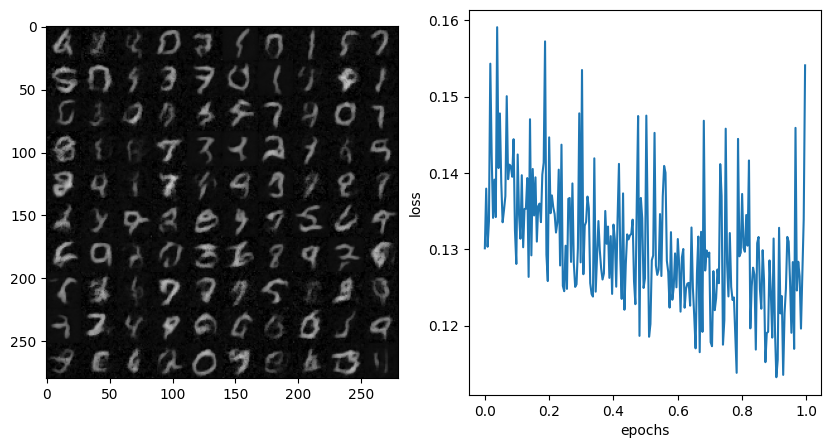

epoch 2


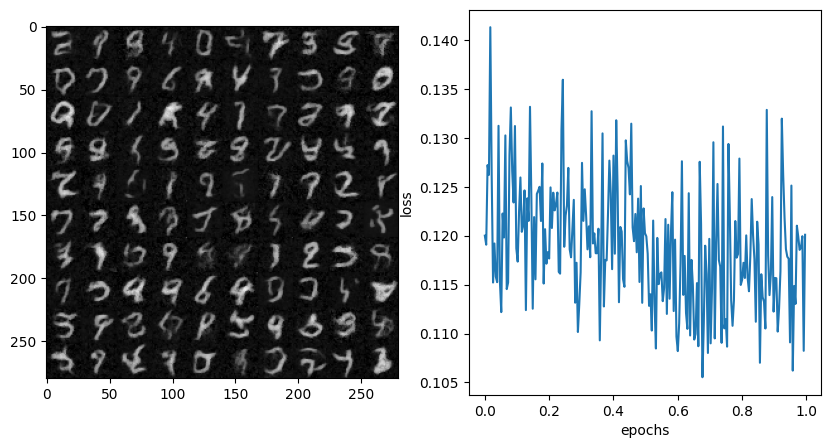

epoch 3


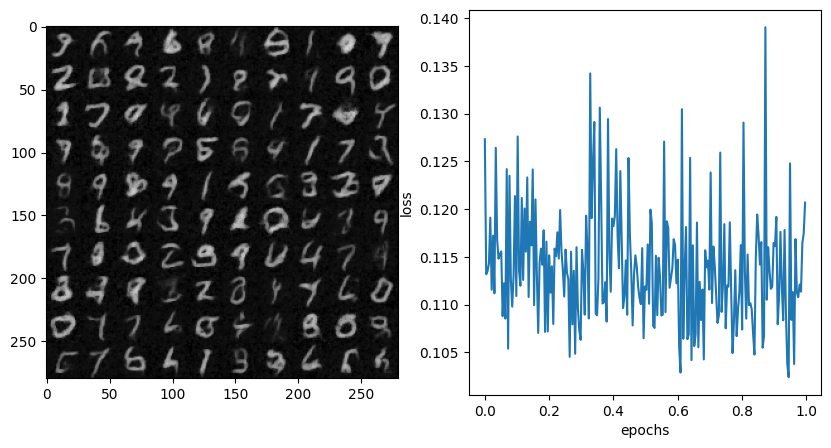

epoch 4


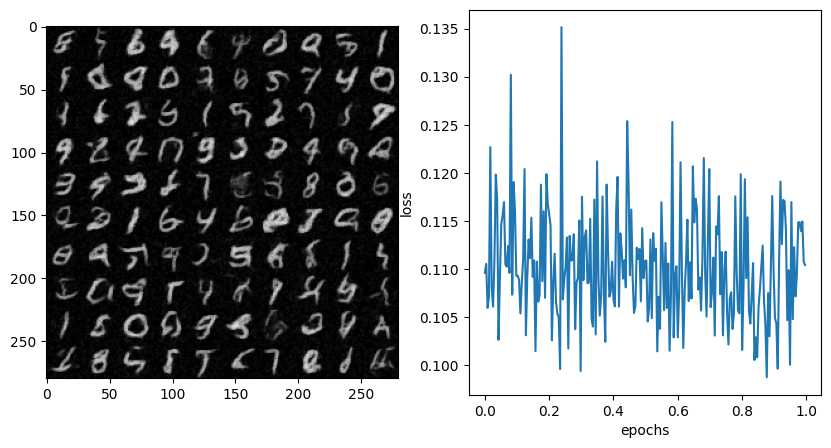

epoch 5


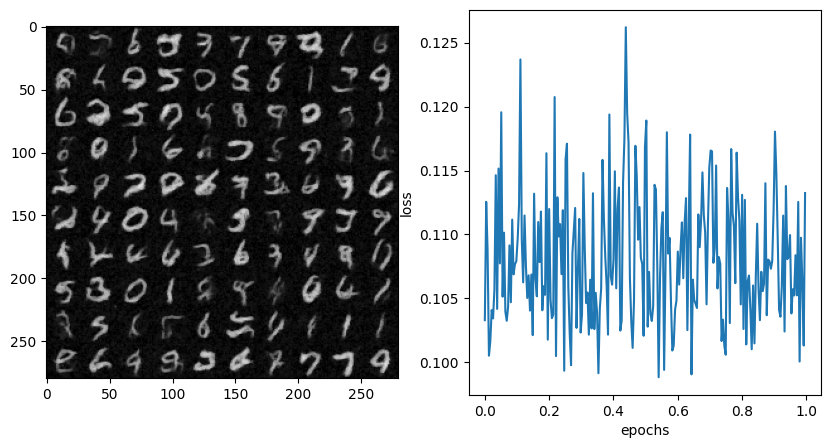

epoch 6


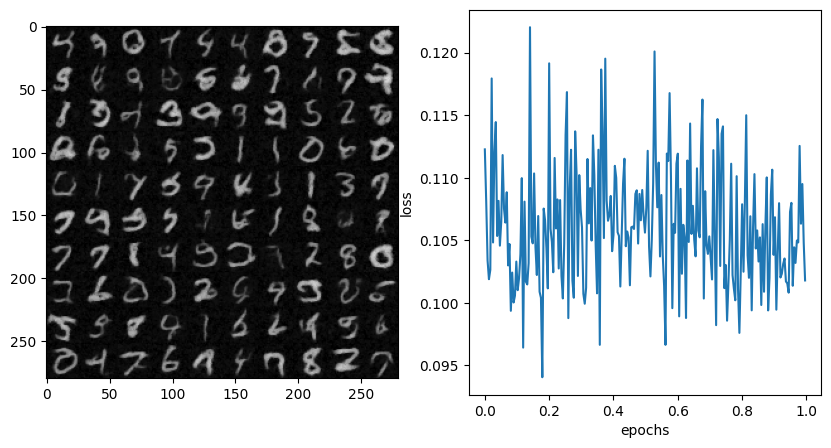

epoch 7


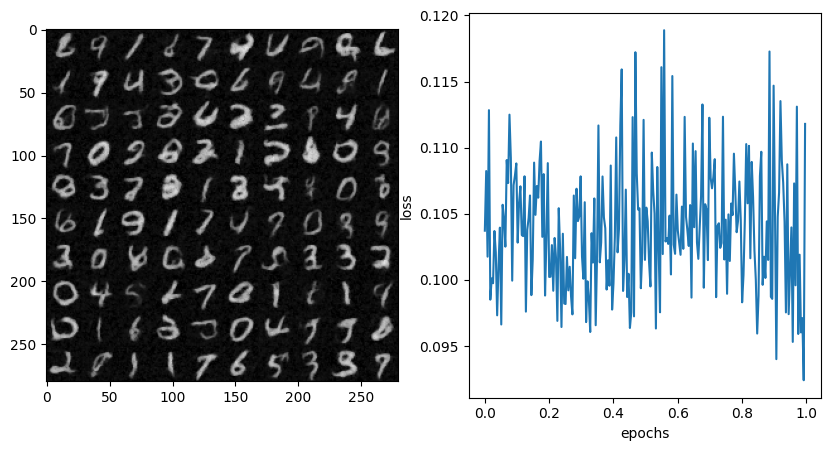

epoch 8


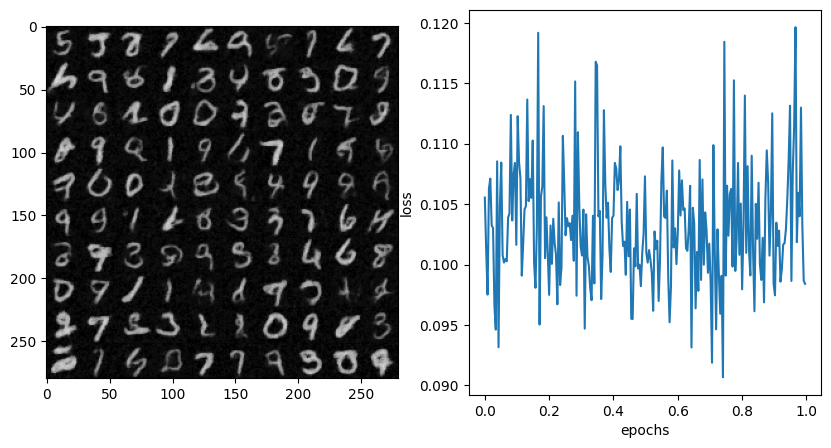

epoch 9


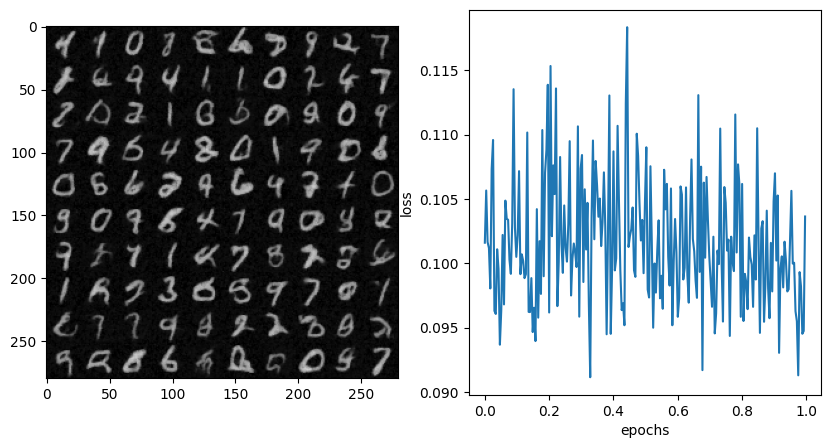

In [17]:
##################
### Problem 1 (e): training
sigma = 0.0
n_feat = 128
n_epochs = 10

model = UNet(in_channels=1, n_feat=n_feat, n_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
FM = ConditionalFlowMatcher(sigma=sigma)

train_main_loop(n_epochs, optimizer, FM, model)
##################


# **2. Ablation Study**

ODE method: dopri5


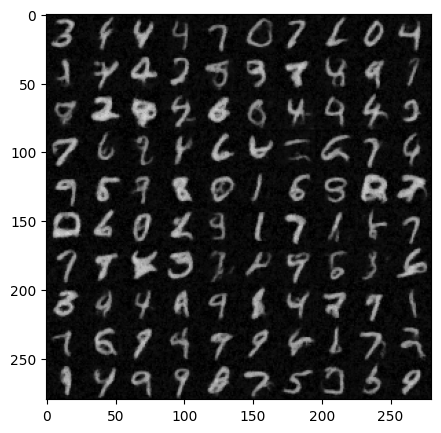

ODE method: dopri8


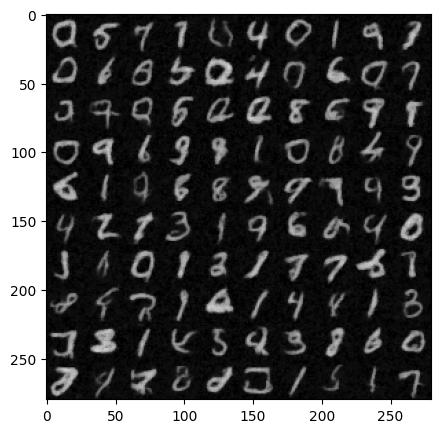

ODE method: bosh3


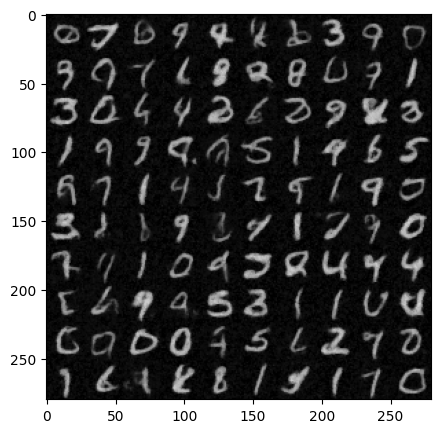

ODE method: fehlberg2


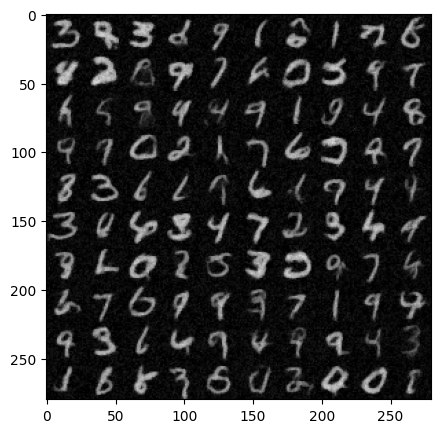

ODE method: adaptive_heun


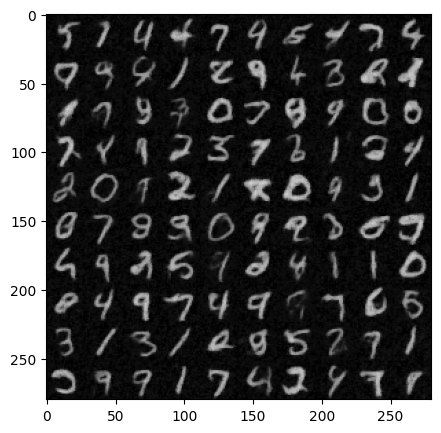

In [18]:
##################
### Problem 2: Ablation Study
##################
for method in ["dopri5", "dopri8", "bosh3", "fehlberg2", "adaptive_heun"]:
    print(f"ODE method: {method}")
    show_results(model, method)

# **3. Gaussian to Gaussian (2D) using a conditional flow**

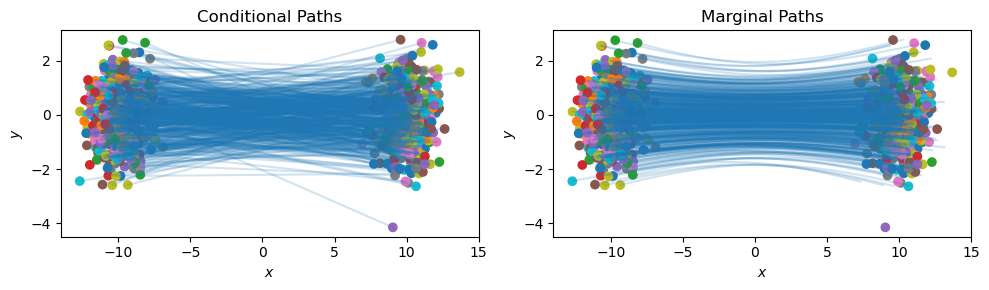

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm

mu = 10
n_samples = 500
n_steps = 100
t_values = np.linspace(0, 1, n_steps)
t_values = t_values

mean_start = np.array([-mu, 0])
mean_end = np.array([mu, 0])
covariance = np.eye(2)

x0_samples = np.random.multivariate_normal(mean_start, covariance, n_samples)
x1_samples = np.random.multivariate_normal(mean_end, covariance, n_samples)


def conditional_paths(x0_samples, x1_samples, mean_end, t_values):
    conditional_paths = []
    for x0, x1 in zip(x0_samples, x1_samples):
        path = [(1 - t) * x0 + t * x1 for t in t_values]
        conditional_paths.append(np.array(path))
    return np.array(conditional_paths)


def marginal_flow(x, t):
    ##################
    ### Problem 3(b): u(x_t)
    ##################
    # mu_t = (1 - t) * mean_start + t * mean_end
    # u_t = (2 * t - 1) / (t**2 + (1 - t) ** 2) * (x - mu_t) + (mean_end - mean_start) # given by AI, also correct

    mu0 = mean_start
    mu1 = mean_end
    var0 = covariance[0, 0]
    var1 = covariance[1, 1]
    var_t_1 = (1 - t) ** 2 * var0
    "This is the original expression."
    # mu1_t = (x * var1 * t + mu1 * var_t_1 - var1 * t * (1 - t) * mu0) / (
    #     var1 * t**2 + var_t_1
    # )
    # if t == 1 and var1 == 1:
    #     u_t = x - var1 * mu0
    # else:
    #     u_t = 1 / (1 - t+1e-15) * (mu1_t - x)
    "To avoid division by zero at t=1, we use the reduced result"
    assert var1 == 1
    u_t = (mu1 * (1 - t) - var1 * t * mu0 + x * t - x * (1 - t) * var1) / (
        var1 * t**2 + var_t_1
    )

    return u_t


def generate_marginal_paths(x0_samples, t_values):
    marginal_paths = []
    for x0 in x0_samples:
        path = [x0]
        x_current = x0
        for t in t_values[1:]:
            u_t = marginal_flow(x_current, t)
            x_current = x_current + u_t * (t_values[1] - t_values[0])
            path.append(x_current)
        marginal_paths.append(np.array(path))
    return np.array(marginal_paths)


conditional_data = conditional_paths(x0_samples, x1_samples, mean_end, t_values)
marginal_data = generate_marginal_paths(x0_samples, t_values)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for path in conditional_data:
    axes[0].plot(path[:, 0], path[:, 1], color="tab:blue", alpha=0.2)
axes[0].set_title("Conditional Paths")
colors = [f"C{i}" for i in range(len(x0_samples))]
axes[0].scatter(x0_samples[:, 0], x0_samples[:, 1], color=colors)
axes[0].scatter(x1_samples[:, 0], x1_samples[:, 1], color=colors)
axes[0].set_xlabel("$x$")
axes[0].set_ylabel("$y$")

for path in marginal_data:
    axes[1].plot(path[:, 0], path[:, 1], color="tab:blue", alpha=0.2)
axes[1].set_title("Marginal Paths")
axes[1].scatter(x0_samples[:, 0], x0_samples[:, 1], color=colors)
axes[1].scatter(x1_samples[:, 0], x1_samples[:, 1], color=colors)
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$y$")

plt.tight_layout()
plt.show()

In [ ]:
# 